# Backpropagation

7 x 6 x 5 x 2 의 4계층 신경망 구조를 작성하여 오차 역전파로 학습이 잘 진행되고, 편미분이 수치 미분의 결과와 동일한지 검증한다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

In [2]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z: np.ndarray):
    return sigmoid(z) * (1.0 - sigmoid(z))

def _gradient_check(analytic, numeric):
    numerator = abs(analytic - numeric)
    denominator = max(analytic, numeric)
    difference = numerator / denominator
    
    # cs231n의 권장 수치는 1e-7이나 그 기준을 맞출 수가 없다.
    if difference < 1e-7:
        print ("Correct!")
    else:
        print("\x1b[31mWrong!\x1b[0m")

def gradient_checking(nn, l = 3):
    nn.__init__()
    nn.train()
    
    if l == 1:
        w = nn.w_1
    elif l == 2:
        w = nn.w_2
    elif l == 3:
        w = nn.w_3
    
    for k in range(w.shape[0]):
        for j in range(w.shape[1]):
            nn.__init__()
            if l == 1:
                nn.w_1[k][j] += nn.h
            elif l == 2:
                nn.w_2[k][j] += nn.h
            elif l == 3:
                nn.w_3[k][j] += nn.h
            nn.query()
            e1 = np.sum((nn.t - nn.out_o) ** 2) / 2

            nn.__init__()
            if l == 1:
                nn.w_1[k][j] -= nn.h
            elif l == 2:
                nn.w_2[k][j] -= nn.h
            elif l == 3:
                nn.w_3[k][j] -= nn.h
            nn.query()
            e2 = np.sum((nn.t - nn.out_o) ** 2) / 2

            if l == 1:
                delta = nn.delta_w_1[k][j]
            elif l == 2:
                delta = nn.delta_w_2[k][j]
            elif l == 3:
                delta = nn.delta_w_3[k][j]

            numeric_gradient = (e1 - e2) / (2 * nn.h)
            # 수치 미분(numeric gradient) 결과가 해석적 미분(analytic gradient)과 동일한지 검증
            print("%.16f, %.16f" % (delta, numeric_gradient), end=", ")
            _gradient_check(delta, numeric_gradient)

        nn.__init__()
        if l == 1:
            nn.b_1[k] += nn.h
        elif l == 2:
            nn.b_2[k] += nn.h
        elif l == 3:
            nn.b_3[k] += nn.h
        nn.query()
        e1 = np.sum((nn.t - nn.out_o) ** 2) / 2

        nn.__init__()
        if l == 1:
            nn.b_1[k] -= nn.h
        elif l == 2:
            nn.b_2[k] -= nn.h
        elif l == 3:
            nn.b_3[k] -= nn.h
        nn.query()
        e2 = np.sum((nn.t - nn.out_o) ** 2) / 2

        print()
        if l == 1:
            delta = nn.delta_b_1[k]
        elif l == 2:
            delta = nn.delta_b_2[k]
        elif l == 3:
            delta = nn.delta_b_3[k]

        numeric_gradient = (e1 - e2) / (2 * nn.h)
        print("%.16f, %.16f" % (delta, numeric_gradient), end=", ")
        _gradient_check(delta, numeric_gradient)
        print() 

In [3]:
class NeuralNetwork:
    def __init__(self):
        self.i = np.array([0.4,-0.2,0.1,0.1,-0.15,0.6,-0.9]).reshape(-1, 1)

        np.random.seed(12)
        self.w_1 = np.random.rand(6, 7)
        self.b_1 = np.random.rand(6).reshape(-1, 1)
        self.w_2 = np.random.rand(5, 6)
        self.b_2 = np.random.rand(5).reshape(-1, 1)
        self.w_3 = np.random.rand(2, 5)
        self.b_3 = np.random.rand(2).reshape(-1, 1)

        self.t = np.array([[0.87503811],[0.83690408]])
        
        self.lr = 0.1
        self.h = 1e-7 
        
        # DEBUG parameters for visualization
        self.delta_w_1_history = []
        self.w_1_history = []
        for _ in range(7):
            self.delta_w_1_history.append([])
            self.w_1_history.append([])
        self.delta_b_1_history = []
        self.b_1_history = []

    def _forward(self):
        self.net_h1 = np.dot(self.w_1, self.i) + self.b_1
        self.out_h1 = sigmoid(self.net_h1)

        self.net_h2 = np.dot(self.w_2, self.out_h1) + self.b_2
        self.out_h2 = sigmoid(self.net_h2)

        self.net_o = np.dot(self.w_3, self.out_h2) + self.b_3
        self.out_o = sigmoid(self.net_o)

    def _backward(self):
        d_o_errors = - (self.t - self.out_o)
        self.delta_w_3 = np.dot(d_o_errors * d_sigmoid(self.net_o), self.out_h2.T)
        self.w_3 += - self.lr * self.delta_w_3
        self.delta_b_3 = d_o_errors * d_sigmoid(self.net_o)
        self.b_3 += - self.lr * self.delta_b_3

        d_h2_errors = np.dot(self.w_3.T, d_o_errors * d_sigmoid(self.net_o))
        self.delta_w_2 = np.dot(d_h2_errors * d_sigmoid(self.net_h2), self.out_h1.T)
        self.w_2 += - self.lr * self.delta_w_2
        self.delta_b_2 = d_h2_errors * d_sigmoid(self.net_h2)
        self.b_2 += - self.lr * self.delta_b_2

        d_h1_errors = np.dot(self.w_2.T, d_h2_errors * d_sigmoid(self.net_h2))
        self.delta_w_1 = np.dot(d_h1_errors * d_sigmoid(self.net_h1), self.i.T)
        self.w_1 += - self.lr * self.delta_w_1
        self.delta_b_1 = d_h1_errors * d_sigmoid(self.net_h1)
        self.b_1 += - self.lr * self.delta_b_1

    def _debug(self):
        for j in range(7):
            self.delta_w_1_history[j].append(self.delta_w_1[0][j]) 
            self.w_1_history[j].append(self.w_1[0][j])
        self.delta_b_1_history.append(self.delta_b_1[0][0])
        self.b_1_history.append(self.b_1[0][0])
        
    def train(self):
        self._forward()
        # backpropagation!
        self._backward()
        
        # for visualization
        self._debug()

    def query(self):
        self._forward()
        
    def result(self):
        print(self.t - self.out_o)

출력 레이어에 activation(여기서는 sigmoid)이 없다면, 아래 처럼 최종 가중치 행렬의 delta 값과, 이전 가중치 행렬에 부여되는 에러값 계산이 다르다.

```
def _forward():
    ...
    # 최종 출력 레이어에 activation(sigmoid)이 없다면,
    out_o = net_o

def _backward():
    ...
    # 최종 출력 레이어에 activation(sigmoid)이 없다면,
    delta_w_3 = np.dot(d_o_errors, out_h2.T)
    delta_b_3 = d_o_errors
    ...
    # 이전 레이어의 에러에도 activation 미분이 생략된다.
    d_h2_errors = np.dot(w_3.T, d_o_errors)
```

히든 레이어의 w1에 대한 delta_w1 수식은 아래와 같다.

$$\frac{\partial E_{total}}{\partial w_{1}} = (\sum\limits_{o}{\frac{\partial E_{total}}{\partial out_{o}} * \frac{\partial out_{o}}{\partial net_{o}} * \frac{\partial net_{o}}{\partial out_{h1}}}) * \frac{\partial out_{h1}}{\partial net_{h1}} * \frac{\partial net_{h1}}{\partial w_{1}}$$

$y_n$ 을 구하는 것이 역전파의 핵심이며 수식에서, $$\frac{\partial out_{o}}{\partial net_{o}} * \frac{\partial net_{o}}{\partial out_{h1}}$$ 부분이다. 즉, 출력 레이어의 activation 미분과 이전 가중치(w5, w6)를 곱한 값이 된다.

In [4]:
nn = NeuralNetwork()

In [5]:
gradient_checking(nn, 3)

0.0020884340416671, 0.0020884341131455, Correct!
0.0022944925136705, 0.0022944925213292, Correct!
0.0025359120035654, 0.0025359120098961, Correct!
0.0026220925711652, 0.0026220924823767, Correct!
0.0026127957312623, 0.0026127957436506, Correct!

0.0028046163835497, 0.0028046163915579, Correct!

0.0032742240271800, 0.0032742239128303, Correct!
0.0035972802437407, 0.0035972802341078, Correct!
0.0039757750770333, 0.0039757750390501, Correct!
0.0041108880274456, 0.0041108880362295, Correct!
0.0040963125436239, 0.0040963125079452, Correct!

0.0043970468623039, 0.0043970468238674, Correct!



In [6]:
# 거의 비슷하여 정답으로 간주할 수 있으나 cs231n의 기준에는 미치지 못한다.
gradient_checking(nn, 2)

0.0002407673085748, 0.0002409511479229, Wrong!
0.0003180687994474, 0.0003183118178762, Wrong!
0.0002162176883807, 0.0002163829618956, Wrong!
0.0002390158000612, 0.0002391982965866, Wrong!
0.0003151281324255, 0.0003153686600060, Wrong!
0.0002522635944823, 0.0002524561983075, Wrong!

0.0005043817367552, 0.0005047669747460, Wrong!

0.0002243399260449, 0.0002244978768856, Wrong!
0.0002963671910759, 0.0002965761143614, Wrong!
0.0002014653090075, 0.0002016074199945, Wrong!
0.0002227079217136, 0.0002228646694274, Wrong!
0.0002936271636772, 0.0002938340022685, Wrong!
0.0002350518285267, 0.0002352174271331, Wrong!

0.0004699681289451, 0.0004702992335848, Wrong!

0.0002811853240944, 0.0002812870856378, Wrong!
0.0003714635470502, 0.0003715979086938, Wrong!
0.0002525145176152, 0.0002526060090269, Wrong!
0.0002791397868826, 0.0002792408405200, Wrong!
0.0003680292252792, 0.0003681624102803, Wrong!
0.0002946115109713, 0.0002947180867408, Wrong!

0.0005890531524247, 0.0005892662226226, Wrong!

0.00010

In [7]:
gradient_checking(nn, 1)

0.0000974372978874, 0.0000974974961876, Wrong!
-0.0000487186489437, -0.0000487487654410, Correct!
0.0000243593244718, 0.0000243742439426, Wrong!
0.0000243593244718, 0.0000243742439426, Wrong!
-0.0000365389867078, -0.0000365616738274, Correct!
0.0001461559468311, 0.0001462461922397, Wrong!
-0.0002192339202466, -0.0002193693057068, Correct!

0.0002435932447185, 0.0002437437317954, Wrong!

0.0000913394440743, 0.0000913891792104, Wrong!
-0.0000456697220372, -0.0000456946720045, Correct!
0.0000228348610186, 0.0000228473663599, Wrong!
0.0000228348610186, 0.0000228473663599, Wrong!
-0.0000342522915279, -0.0000342708066786, Correct!
0.0001370091661115, 0.0001370838078468, Wrong!
-0.0002055137491673, -0.0002056257334543, Correct!

0.0002283486101858, 0.0002284729523627, Wrong!

0.0000386111993653, 0.0000386394215235, Wrong!
-0.0000193055996826, -0.0000193198061715, Correct!
0.0000096527998413, 0.0000096598336968, Wrong!
0.0000096527998413, 0.0000096598336968, Wrong!
-0.0000144791997620, -0.0000

In [8]:
# 실제 학습이 잘 되는지 확인
nn.__init__()
for _ in range(3000): 
    nn.train()
nn.query()
nn.result()

[[-0.00000015]
 [ 0.        ]]


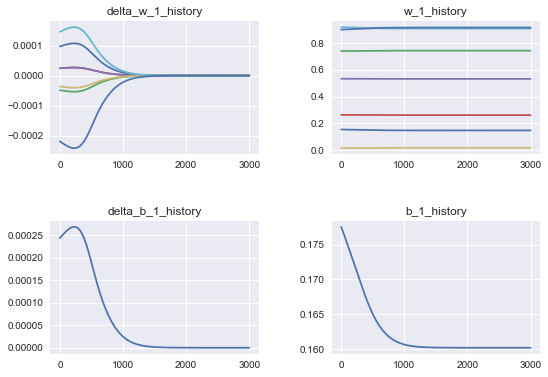

In [9]:
# plot with various axes scales
plt.figure(1)

for j in range(7):
    plt.subplot(221)
    plt.plot(nn.delta_w_1_history[j])
    plt.title("delta_w_1_history")
        
    plt.subplot(222)
    plt.plot(nn.w_1_history[j])
    plt.title("w_1_history")
    
plt.subplot(223)
plt.plot(nn.delta_b_1_history)
plt.title("delta_b_1_history")

plt.subplot(224)
plt.plot(nn.b_1_history)
plt.title("b_1_history")

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
# https://matplotlib.org/gallery/pyplots/pyplot_scales.html#sphx-glr-gallery-pyplots-pyplot-scales-py
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

w_1의 기울기가 0에 이르는 지점이 bias 학습이 함께 진행될때는 1,200 epoch 정도이나,  
bias 학습을 하지 않으면 1,500 epoch 이상을 넘어선다.

In [10]:
nn.w_1

array([[ 0.14722202,  0.74352011,  0.26157981,  0.53200419,  0.01717777,
         0.90833578,  0.91633169],
       [ 0.02672103,  0.96029954,  0.13553422,  0.28215325,  0.60859583,
         0.93417454,  0.86781144],
       [-0.00033641,  0.52252385,  0.55138872,  0.4847285 ,  0.76910752,
         0.15682329,  0.77040064],
       [ 0.01250873,  0.13936071,  0.11419775,  0.30782232,  0.67456555,
         0.45877818,  0.8348457 ],
       [ 0.28253518,  0.73665178,  0.70085945,  0.32580658,  0.33729188,
         0.96748067,  0.64044822],
       [ 0.94588999,  0.76968742,  0.82390337,  0.40553442,  0.45296724,
         0.39399632,  1.00509112]])

# 미분 계산

In [11]:
import sympy
sympy.init_printing(use_latex='mathjax')
w11, x1, w12, x2, w13, x3, b3 = sympy.symbols('w11 x1 w12 x2 w13 x3 b3')
z = w11 * x1 + w12 * x2 + w13 * x3 + b3
z

b₃ + w₁₁⋅x₁ + w₁₂⋅x₂ + w₁₃⋅x₃

In [12]:
sympy.Derivative(z, b3).doit()

1